# Prepare grids for gravity inversion

In [2]:
import pygmt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr 
from pyproj import Transformer

import os
os.getcwd()

from pygmt import session_management
session_management.end()
session_management.begin()

In [3]:
zoom=0e3
shift=0e3
buffer=300e3

e_inv = -560000+zoom
w_inv = 400000-zoom
n_inv = -1400000+zoom-shift
s_inv = -440000-zoom-shift

"""
# for Ross Embayment
e_fig = -760_000
w_fig = -2_200_000 #N extent
n_fig = 600_000
s_fig = -350_000 #S extent
"""

inv_reg = [e_inv, w_inv, n_inv, s_inv]
e_buff, w_buff, n_buff, s_buff = int(e_inv-buffer), int(w_inv+buffer), int(n_inv-buffer), int(s_inv+buffer)
buffer_reg = [e_buff, w_buff, n_buff, s_buff]
buffer_reg_str=f'{e_buff}/{w_buff}/{n_buff}/{s_buff}'
inv_reg_ll = "-180/180/-90/-71"

fig_height = 80
fig_width = fig_height*(w_inv-e_inv)/(s_inv-n_inv)

inv_ratio = (s_inv-n_inv)/(fig_height/1000)
buffer_ratio = (s_buff-n_buff)/(fig_height/1000)

inv_proj = f"x1:{inv_ratio}"
buffer_proj = f"x1:{buffer_ratio}"

inv_proj_ll = f"s0/-90/-71/1:{inv_ratio}"
buffer_proj_ll = f"s0/-90/-71/1:{buffer_ratio}"

antreg = "-3330000/1900000/-3330000/1850000"

# BedMachine Data
Add geoid to convert to WGS84, for grav inv want in geoid

In [14]:
# !gmt grdmath /Volumes/arc_04/tankerma/Datasets/Bedmachine2/BedMachineAntarctica_2020-07-15_v02.nc?surface /Volumes/arc_04/tankerma/Datasets/Bedmachine2/BedMachineAntarctica_2020-07-15_v02.nc?geoid ADD = /Volumes/arc_04/tankerma/Datasets/Bedmachine2/BedMachine_surface_wgs.nc
# !gmt grdmath /Volumes/arc_04/tankerma/Datasets/Bedmachine2/BedMachineAntarctica_2020-07-15_v02.nc?bed /Volumes/arc_04/tankerma/Datasets/Bedmachine2/BedMachineAntarctica_2020-07-15_v02.nc?geoid ADD = /Volumes/arc_04/tankerma/Datasets/Bedmachine2/BedMachine_bed_wgs.nc

Clip to around Ross Embayment

In [45]:
!gmt grdsample /Volumes/arc_04/tankerma/Datasets/Bedmachine2/BedMachineAntarctica_2020-07-15_v02.nc?surface -R-1560000/1400000/-2400000/560000 -rg -Ginversion_layers/bedmachine/BedMachine_surface.nc -I5000
!gmt grdsample /Volumes/arc_04/tankerma/Datasets/Bedmachine2/BedMachineAntarctica_2020-07-15_v02.nc?bed -R-1560000/1400000/-2400000/560000 -rg -Ginversion_layers/bedmachine/BedMachine_bed.nc -I5000
!gmt grdsample /Volumes/arc_04/tankerma/Datasets/Bedmachine2/BedMachineAntarctica_2020-07-15_v02.nc?thickness -R-1560000/1400000/-2400000/560000 -rg -Ginversion_layers/bedmachine/BedMachine_thickness.nc -I5000

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


### SURFACE
Bedmachine surface, NaN's set to 0

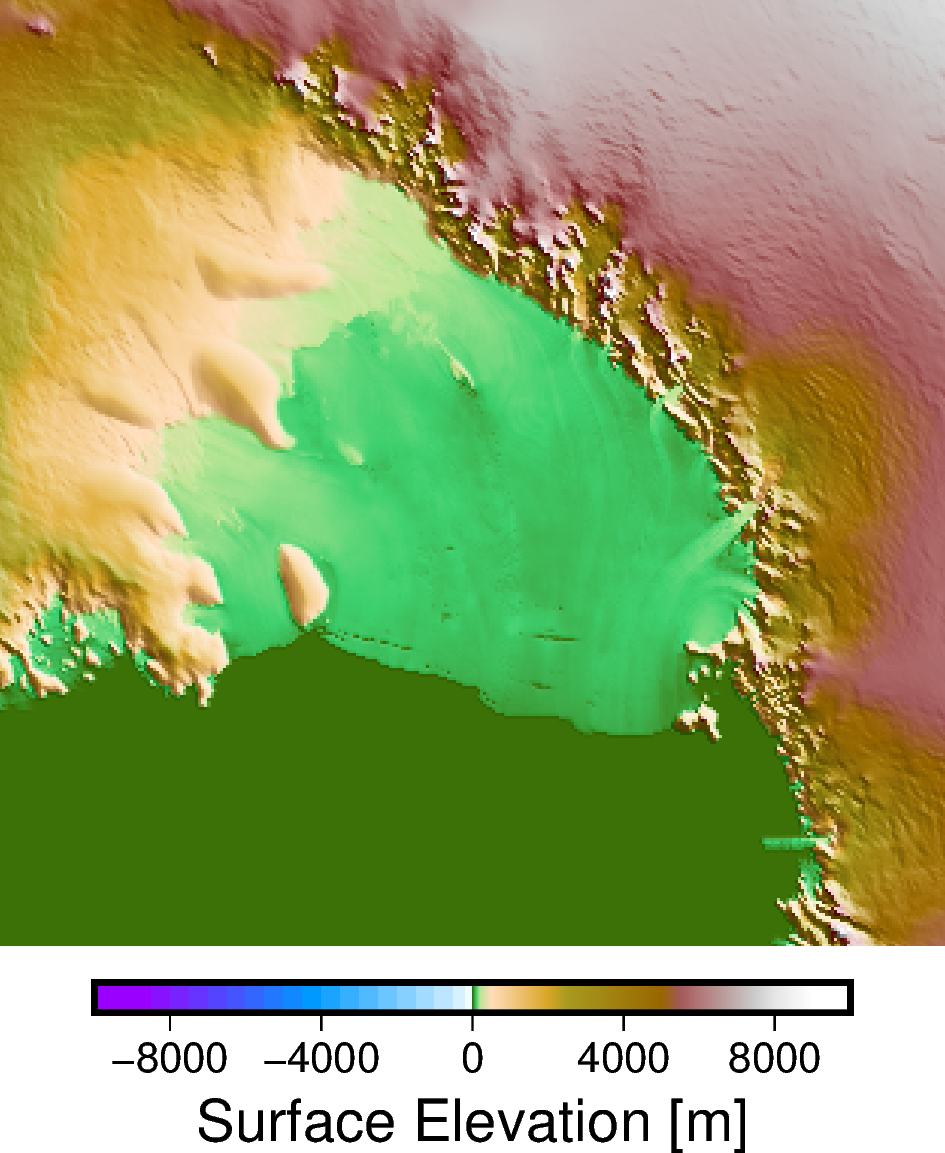

In [10]:
!gmt grdmath inversion_layers/bedmachine/BedMachine_surface.nc 0 DENAN = inversion_layers/bedmachine/BedMachine_surface_filled.nc
fig=pygmt.Figure()
grid ='inversion_layers/bedmachine/BedMachine_surface_filled.nc',
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading='grdgradient+a45/45+nt1+m0', 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa4000+l"Surface Elevation [m]"')
fig.show()

### ICEBASE
BedMachine surface-thickness, NaN's set to 0

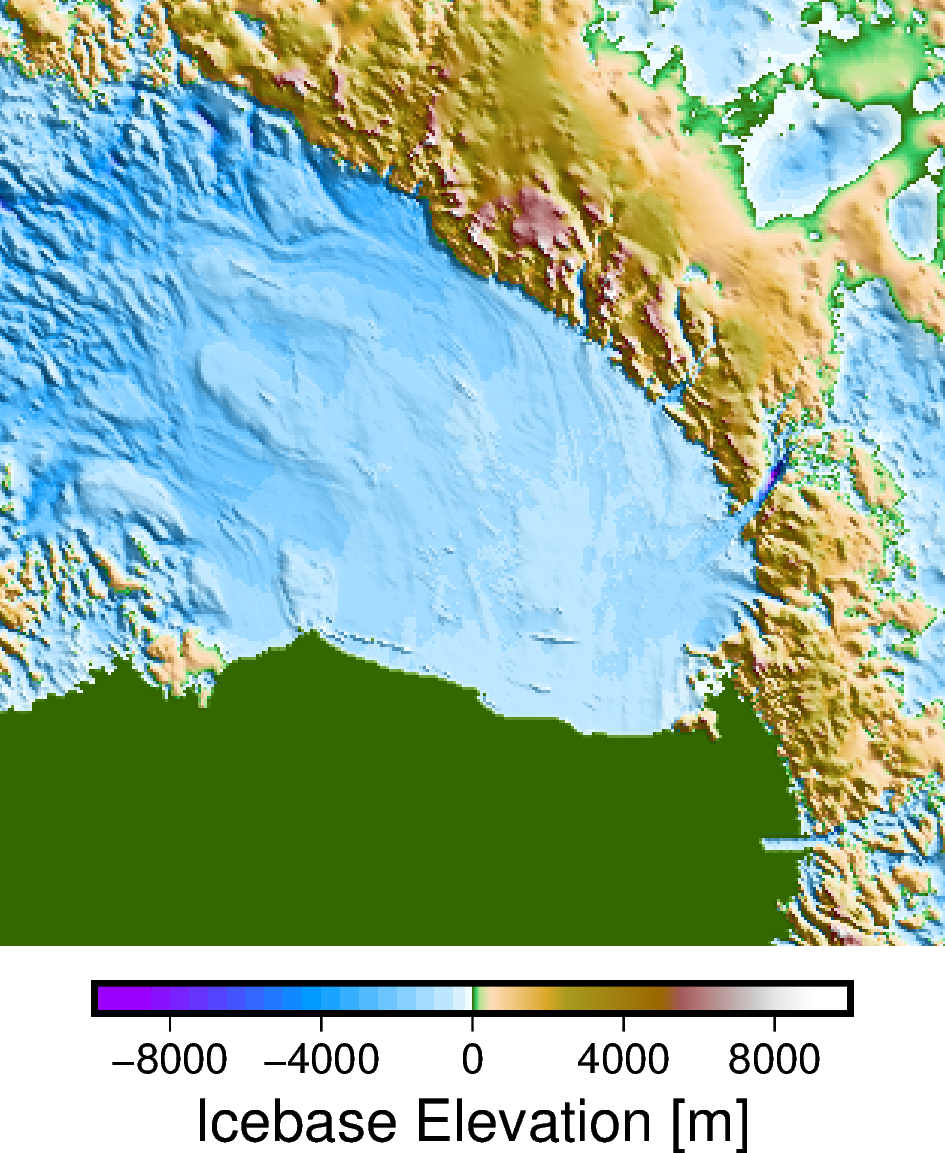

In [11]:
!gmt grdmath inversion_layers/bedmachine/BedMachine_surface.nc inversion_layers/bedmachine/BedMachine_thickness.nc SUB = inversion_layers/bedmachine/BedMachine_icebase.nc
!gmt grdmath inversion_layers/bedmachine/BedMachine_icebase.nc 0 DENAN = inversion_layers/bedmachine/BedMachine_icebase_filled.nc

fig=pygmt.Figure()
grid ='inversion_layers/bedmachine/BedMachine_icebase_filled.nc'
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading='grdgradient+a45/45+nt1+m0', 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa4000+l"Icebase Elevation [m]"')
fig.show()

### BED
BedMachine bed

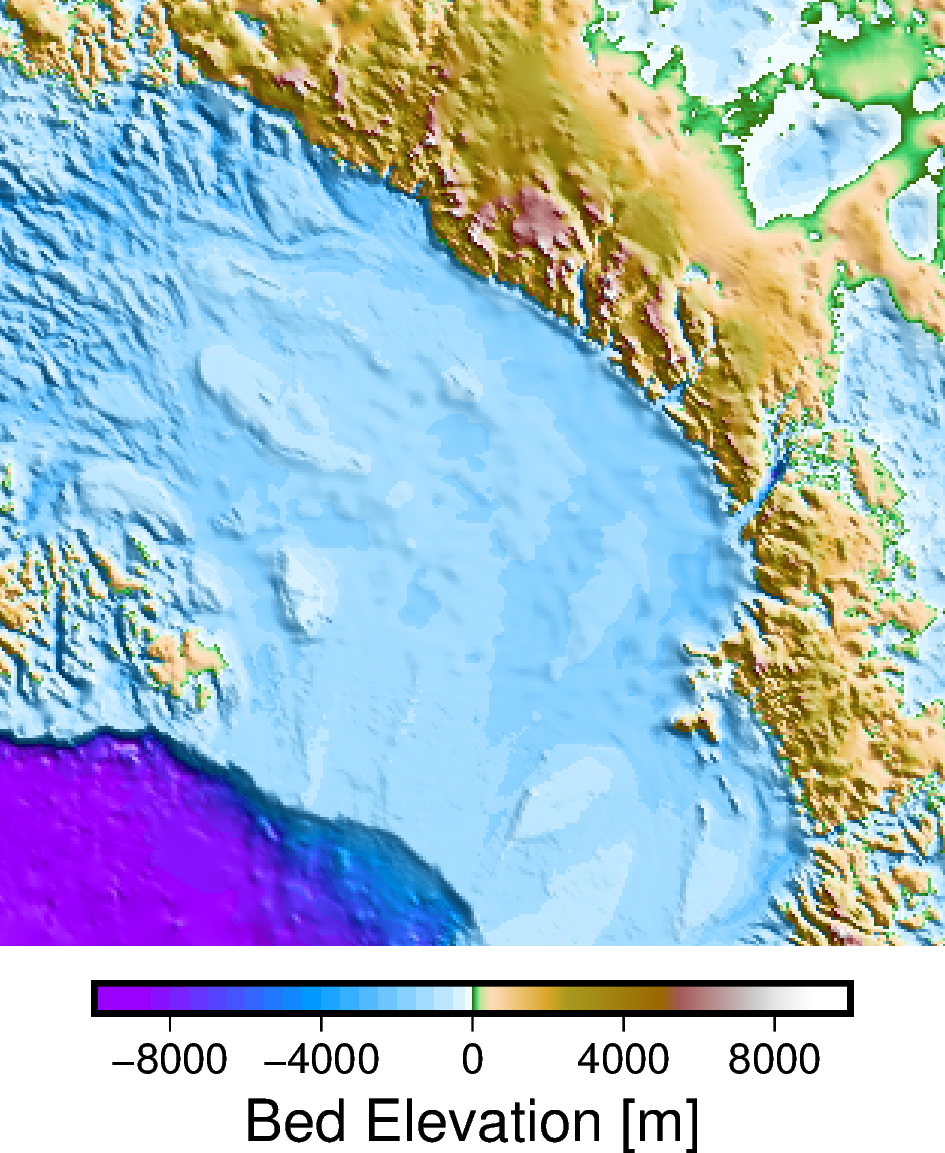

In [12]:
fig=pygmt.Figure()
grid ='inversion_layers/bedmachine/BedMachine_bed.nc'
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading='grdgradient+a45/45+nt1+m0', 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa4000+l"Bed Elevation [m]"')
fig.show()

# Bedmap2 Data
Add geoid to convert to WGS84, for grav inv want in geoid

Bedmap2 surface, NaN's set to 0

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


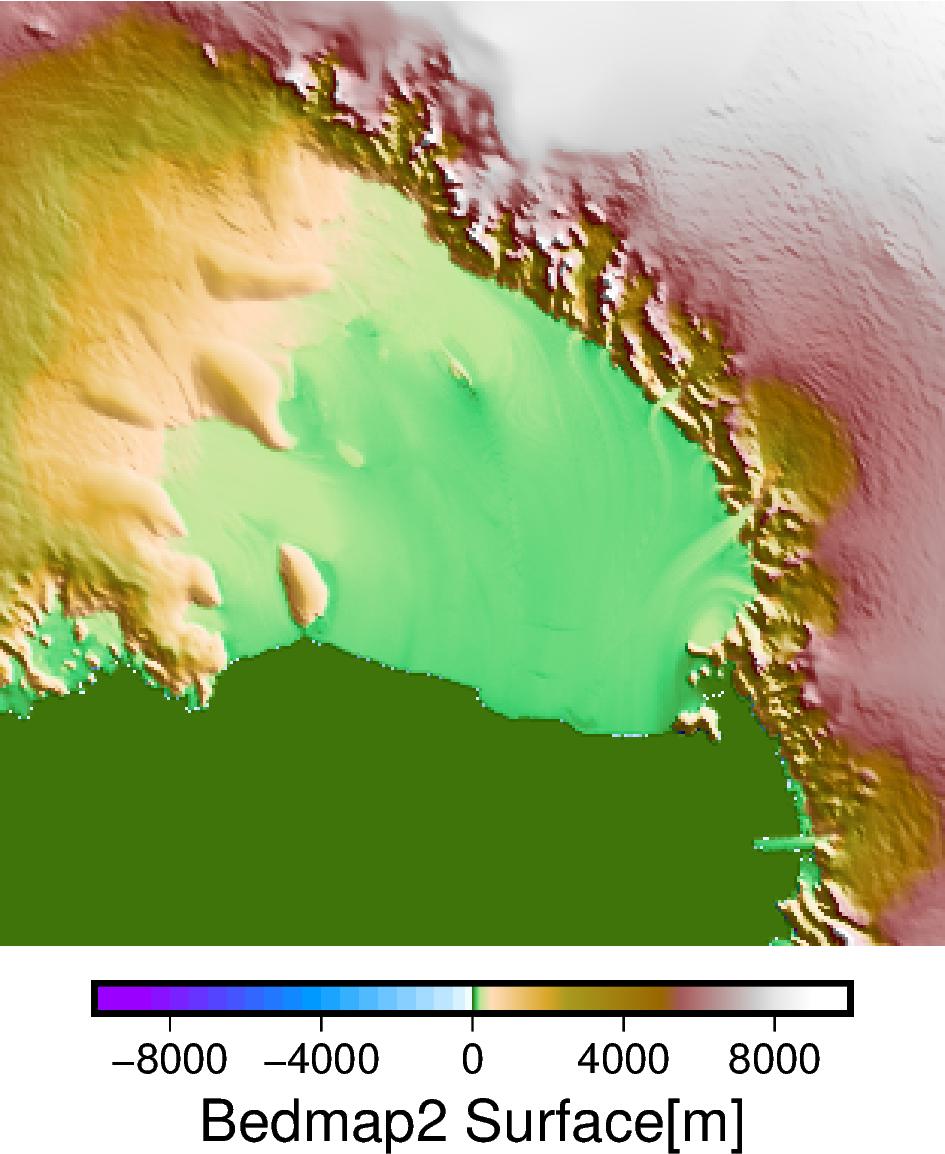

In [13]:
fname='/Volumes/arc_04/tankerma/Datasets/bedmap2/bedmap2_tiff/bedmap2_surface.tif'
# fname2='/Volumes/arc_04/tankerma/Datasets/bedmap2/bedmap2_tiff/gl04c_geiod_to_WGS84.tif'
# not sure if should convert to WGS than fill nans with 0, or vice-versa
# !gmt grdmath {fname} {fname2} ADD = bedmap2_surface_WGS84.nc
!gmt grdmath {fname} 0 DENAN = inversion_layers/bedmap2_surface_filled.nc
# !gmt grdmath -Df bedmap2_surface.tif gl04c_geoid_to_WGS84.tif ADD = bedmap2_surface_WGS_84.tif
!gmt grdsample inversion_layers/bedmap2_surface_filled.nc -Ginversion_layers/bedmap2_surface_filled_RIS_5k.nc -R-1560000/1400000/-2400000/560000 -I5000
# !gmt grdmath -Df inversion_layers/bedmap2_surface_filled_RIS_5k.nc 0 DENAN = layers/bedmap2_surface_WGS_84_RIS_5k_filled.nc

fig=pygmt.Figure()
grid ='inversion_layers/bedmap2_surface_filled_RIS_5k.nc'
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading='grdgradient+a45/45+nt1+m0', 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa4000+l"Bedmap2 Surface[m]"')
fig.show()

In [ ]:
!gmt grdmath -Df bedmap2_surface.tif bedmap2_thickness.tif SUB = bedmap2_icebase.nc
!gmt grdsample bedmap2_icebase.nc -Gbedmap2_icebase_RIS.nc -R-760000/600000/-1600000/-240000
!gmt grdmath -Df bedmap2_icebase.nc gl04c_geiod_to_WGS84.tif ADD = bedmap2_icebase_WGS_84.tif
!gmt grdsample bedmap2_icebase_WGS_84.tif -Gbedmap2_icebase_WGS_84_RIS_5k.nc -R-760000/600000/-1600000/-240000 -I5000+e
!gmt grdmath -Df bedmap2_icebase_WGS_84_RIS_5k.nc 0 DENAN = layers/bedmap2_icebase_WGS_84_RIS_5k_filled.nc
!gmt grd2xyz bedmap2_icebase_WGS_84_RIS_5k_filled.nc > bedmap2_icebase_WGS_84_RIS_5k_filled.csv


In [ ]:
!gmt grdsample bedmap2_thickness.tif -Gbedmap2_thickness_RIS_5k.nc -R-1560000/1400000/-2400000/560000 -I5000+e

In [ ]:
!gmt grdmath -Df layers/bedmap2_surface_WGS_84_RIS_5k_filled.nc bedmap2_thickness_RIS_5k.nc SUB = bedmap2_icebase_WGS_84_RIS_5k.nc

In [ ]:
!gmt grdmath -Df bedmap2_icebase_WGS_84_RIS_5k.nc 0 DENAN = layers/bedmap2_icebase_WGS_84_RIS_5k_filled.nc

In [ ]:
make_fig()
fig.grdimage(grid ='layers/bedmap2_icebase_WGS_84_RIS_5k_filled.nc', cmap ='globe', region=risreg, projection=risproj, shading='grdgradient+a45/45+nt1+m0', nan_transparent=True)
fig.colorbar(cmap ='globe', position = pos_str,frame = 'xa2000+l"Ice Base [m]"', box = '+gblack+p0.5p,black+c3p')
fig.show()

#### Bedmap2 bed

In [ ]:
!gmt grdmath -Df bedmap2_bed.tif gl04c_geiod_to_WGS84.tif ADD = bedmap2_bed_WGS_84.tif

In [ ]:
# !gmt grdsample bedmap2_bed_WGS_84.tif -Glayers/bedmap2_bed_WGS_84_RIS_5k.nc -R-1560000/1400000/-2400000/560000 -I5000+e

In [ ]:
!gmt grd2xyz layers/bedmap2_bed_WGS_84_RIS_5k.tif > bedmap2_bed_WGS_84_RIS_5k.csv

In [ ]:
make_fig()
fig.grdimage(grid ='layers/bedmap2_bed_WGS_84_RIS_5k.nc', cmap ='globe', projection=risproj, shading='grdgradient+a45/45+nt1+m0', region=risreg, nan_transparent=True)
fig.colorbar(cmap ='globe', position = pos_str,frame = 'xa2000+l"Bed Elevation [m]"', box = '+gblack+p0.5p,black+c3p')
fig.show()

#### Bedmap2 bed minus bedmachine bed

In [ ]:
!gmt grdmath -Df layers/bedmap2_bed_WGS_84_RIS_5k.nc layers/BedMachine_bed_5k.nc SUB = layers/tmp_bedmap2_bedmachine_bed_diff.nc 

In [ ]:
make_fig()
pygmt.makecpt(cmap='polar', series='-200/200', background='o')
fig.grdimage(grid ='layers/tmp_bedmap2_bedmachine_bed_diff.nc', cmap =True, projection=risproj, shading='grdgradient+a45/45+nt1+m0', region=risreg, nan_transparent=True)
fig.colorbar(cmap =True, position = pos_str,frame = 'xa50+l"Bed Elevation Difference [m]"', box = '+gblack+p0.5p,black+c3p')
fig.show()

# Basement

ANTASed Model

In [55]:
file ='/Volumes/arc_04/tankerma/Datasets/ANTASed/0.1_lim_b.dat'
df = pd.read_csv(file, header=None, 
                delim_whitespace=True, 
                names=['x_100km', 'y_100km', 'thick_km'])

df['x'], df['y'], df['thick'] = df.x_100km*100000, df.y_100km*100000, df.thick_km*1000

# pygmt.xyz2grd(data=df[['x','y','thick']], region="-1560000/1400000/-2400000/560000", spacing = 5000, registration='g', outgrid='/Volumes/arc_04/tankerma/Datasets/ANTASed/ANTASed_thick.nc')
pygmt.surface(data=df[['x','y','thick']], region="-1560000/1400000/-2400000/560000", spacing = 5000, registration='g', outgrid='/Volumes/arc_04/tankerma/Datasets/ANTASed/ANTASed_thick.nc')

!gmt grdmath -Df inversion_layers/bedmachine/BedMachine_bed.nc /Volumes/arc_04/tankerma/Datasets/ANTASed/ANTASed_thick.nc SUB = /Volumes/arc_04/tankerma/Datasets/ANTASed/ANTASed_basement.nc
!gmt grdsample inversion_layers/Ross_Embayment_basement_filt.nc -I5000 -R-1560000/1400000/-2400000/560000 -rg -Ginversion_layers/Ross_Embayment_basement_filt_resample.nc
!gmt grdblend inversion_layers/Ross_Embayment_basement_filt_resample.nc /Volumes/arc_04/tankerma/Datasets/ANTASed/ANTASed_basement.nc -Cf -Ginversion_layers/ANTASed_mag_basement_merged.nc


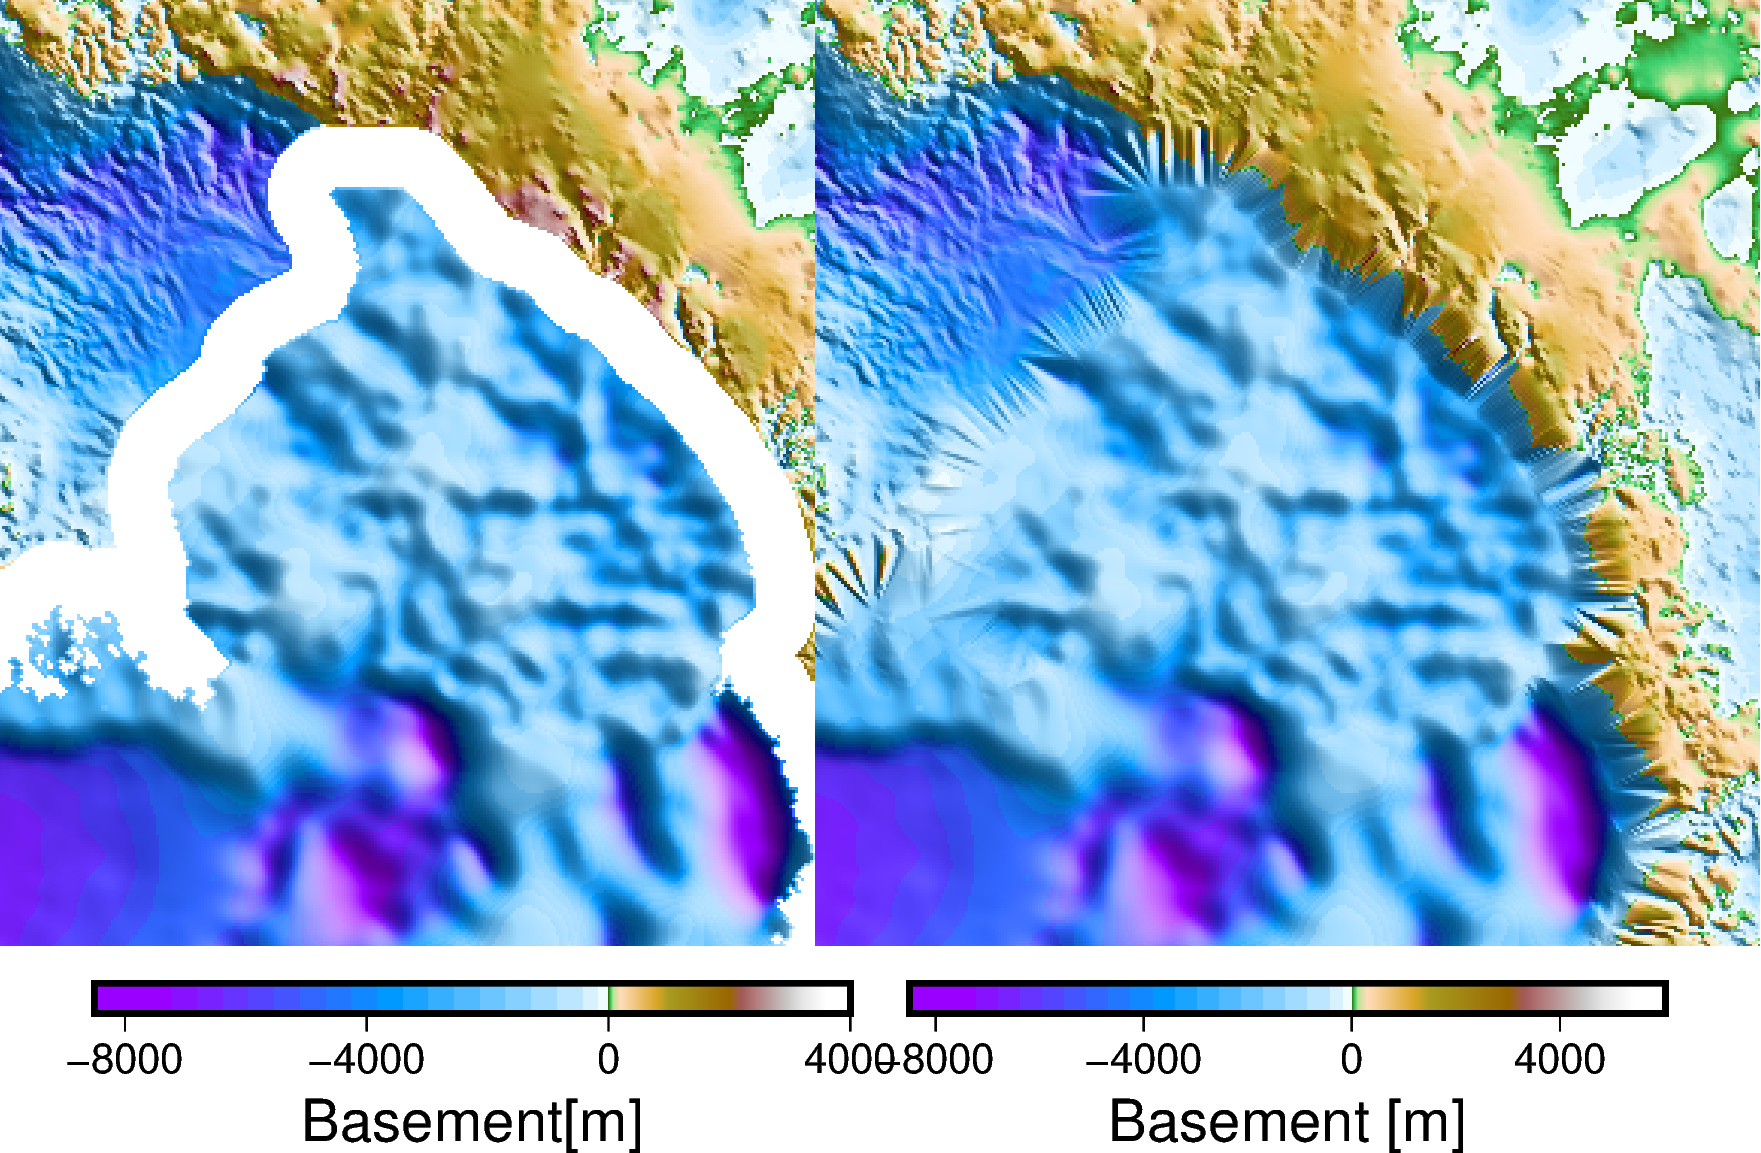

In [17]:
!gmt grd2xyz inversion_layers/Ross_Embayment_basement_filt.nc -s > inversion_layers/Ross_Embayment_basement_filt.xyz
pygmt.surface(data = 'inversion_layers/Ross_Embayment_basement_filt.xyz', 
              spacing='5000', 
              region='-1560000/1400000/-2400000/560000',
              M='20c',
              outgrid='inversion_layers/RE_basement_buffer.nc', verbose='e') 
!gmt grdsample inversion_layers/Ross_Embayment_basement_filt.nc -I5000 -R-1560000/1400000/-2400000/560000 -rg -Ginversion_layers/Ross_Embayment_basement_filt_resample.nc
!gmt grdsample inversion_layers/RE_basement_buffer.nc -I5000 -R-1560000/1400000/-2400000/560000 -rg -Ginversion_layers/RE_basement_buffer.nc
!gmt grdmath inversion_layers/RE_basement_buffer.nc ISNAN = inversion_layers/RE_basement_buffer_mask.nc

!gmt grdmath inversion_layers/RE_basement_buffer_mask.nc /Volumes/arc_04/tankerma/Datasets/ANTASed/ANTASed_basement.nc MUL = inversion_layers/ANTASed_basement_buffer.nc
!gmt grdmath inversion_layers/ANTASed_basement_buffer.nc 0 NAN = inversion_layers/ANTASed_basement_buffer_mask.nc
!gmt grdblend inversion_layers/Ross_Embayment_basement_filt_resample.nc inversion_layers/ANTASed_basement_buffer_mask.nc -Cf -Ginversion_layers/ANTASed_mag_basement.nc

grid = xr.load_dataarray('inversion_layers/ANTASed_mag_basement.nc').rio.write_crs("epsg:3031")
filled = grid.rio.interpolate_na(method='cubic')
filled.to_netcdf('inversion_layers/ANTASed_mag_basement_filled.nc')

fig=pygmt.Figure()
grid='inversion_layers/ANTASed_mag_basement.nc'
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading='grdgradient+a45/45+nt1+m0', 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa4000+l"Basement[m]"')

fig.shift_origin(xshift='w+0.5c')

grid='inversion_layers/ANTASed_mag_basement_filled.nc'
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading='grdgradient+a45/45+nt1+m0', 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa4000+l"Basement [m]"')
fig.show()

Lindeque sed thickness

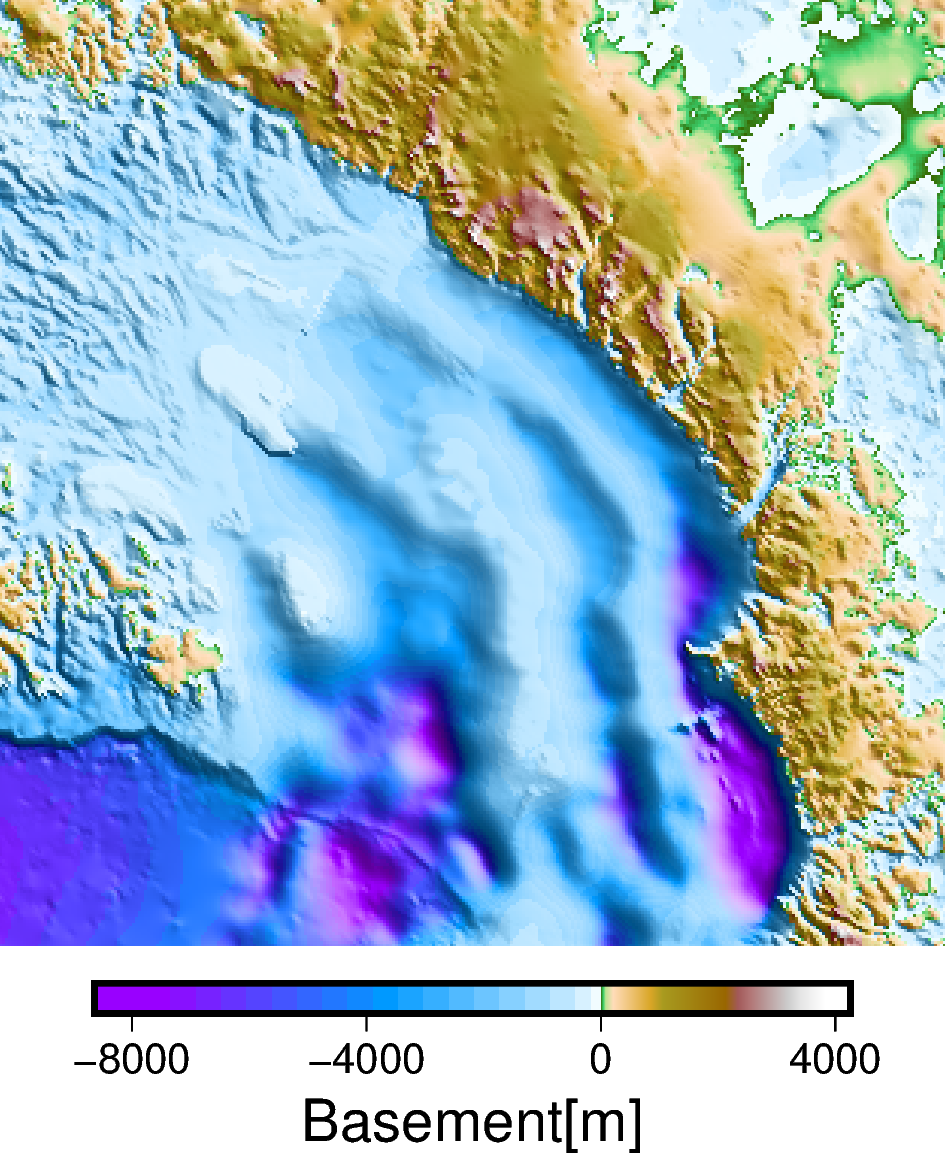

In [11]:
# prep ANTOSTRAT basement (from Lindeque et al. sediment thickness)
# resample lindeque sed thickness to match bedmap spacing / region
lindeque_sed = pygmt.grdsample(grid='../RIS_basement_sediment/data/input/sedthick_total_v2_5km_epsg3031.nc', 
                region='-1560000/1400000/-2400000/560000',
                spacing='5000', registration='g',)

lindeque_sed=lindeque_sed.fillna(0)

# subtract sed thickness from bed to get basement
bed = xr.load_dataarray('inversion_layers/bedmachine/BedMachine_bed.nc')

lindeque_basement = bed - lindeque_sed 

# filter with 20km Gaussian filter to remove bathymetry-induced variations
# lindeque_basement_filt = pygmt.grdfilter(grid=lindeque_basement, 
#                 filter='g20000', nans='r', distance='0', 
#                 # outgrid='../data/results/Lindeque_bedmachine_basement.nc'
#                 )
lindeque_basement.to_netcdf('inversion_layers/lindeque_basement.nc')

fig=pygmt.Figure()
grid='inversion_layers/lindeque_basement.nc'
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading='grdgradient+a45/45+nt1+m0', 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa4000+l"Basement[m]"')
fig.show()

Basement merged to Bedmachine Bed

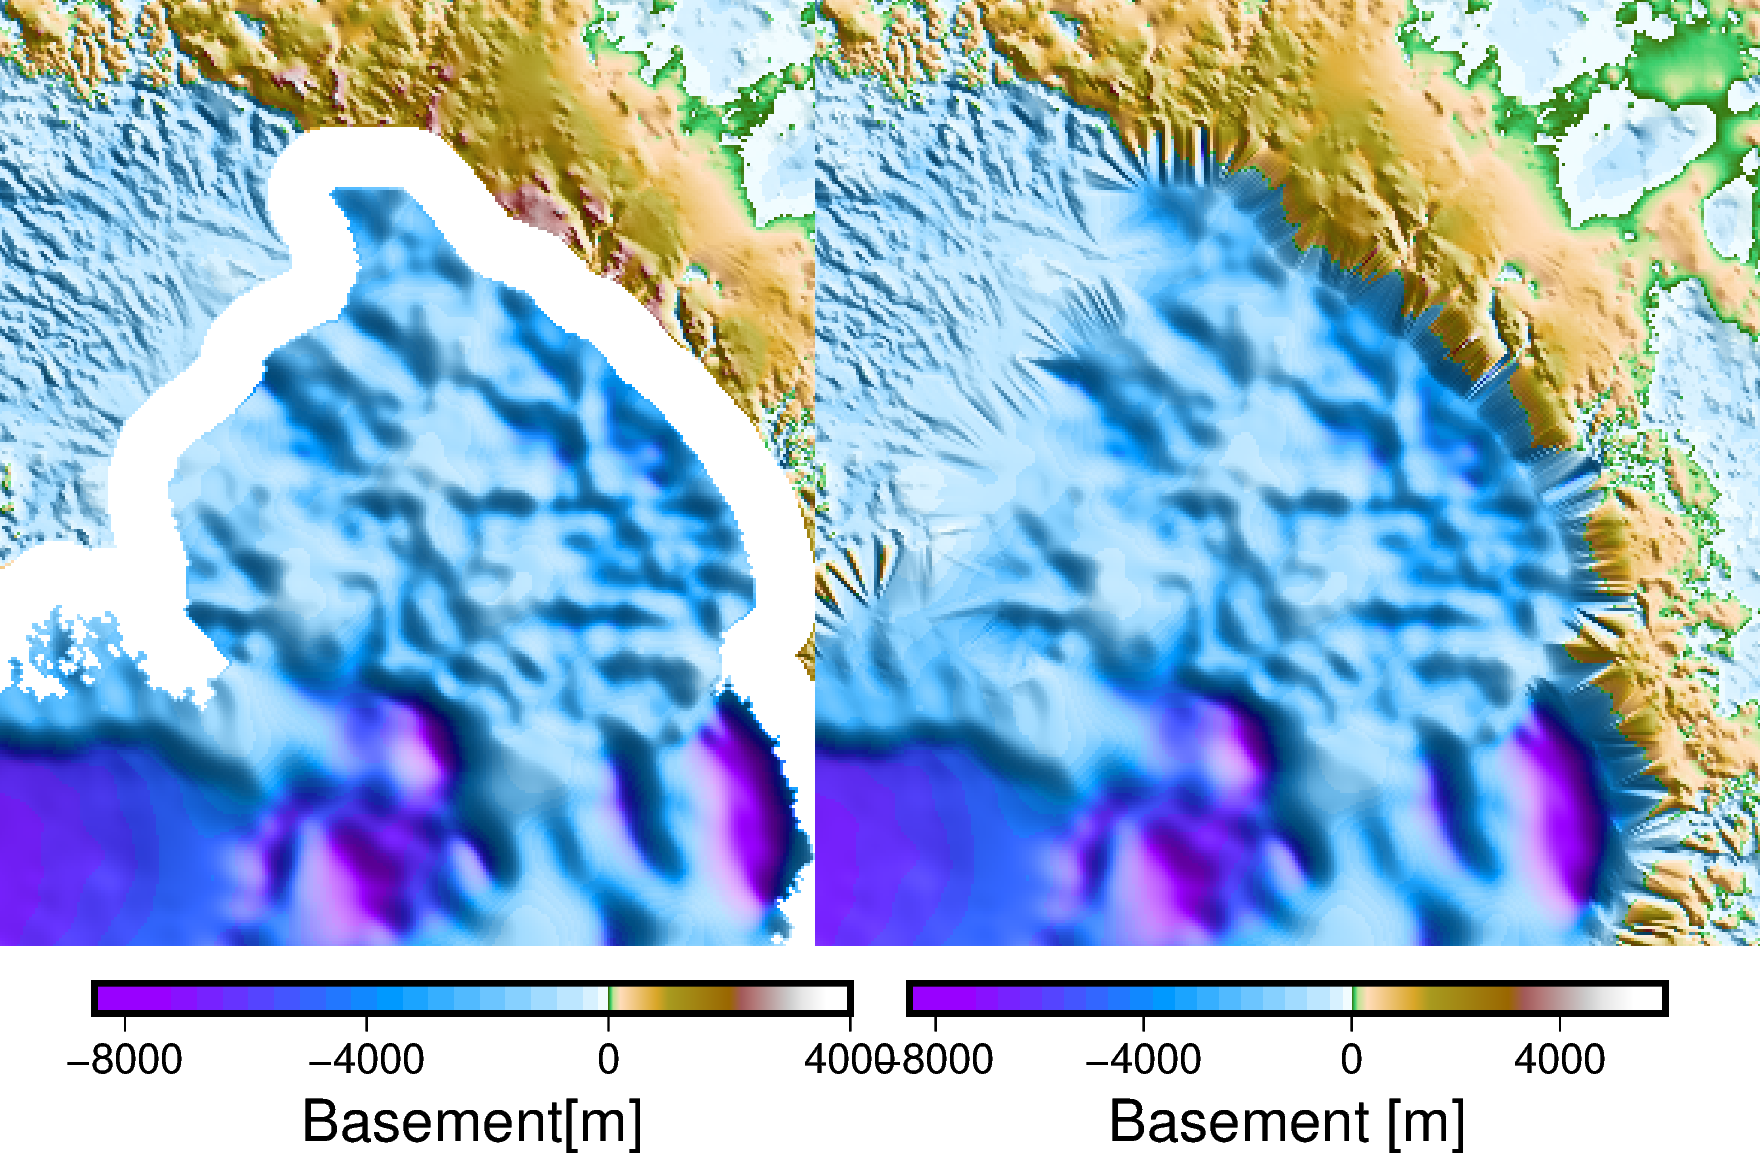

In [18]:
!gmt grd2xyz inversion_layers/Ross_Embayment_basement_filt.nc -s > inversion_layers/Ross_Embayment_basement_filt.xyz
pygmt.surface(data = 'inversion_layers/Ross_Embayment_basement_filt.xyz', 
              spacing='5000', 
              region='-1560000/1400000/-2400000/560000',
              M='20c',
              outgrid='inversion_layers/RE_basement_buffer.nc', verbose='e') 
!gmt grdsample inversion_layers/Ross_Embayment_basement_filt.nc -I5000 -R-1560000/1400000/-2400000/560000 -rg -Ginversion_layers/Ross_Embayment_basement_filt_resample.nc
!gmt grdsample inversion_layers/RE_basement_buffer.nc -I5000 -R-1560000/1400000/-2400000/560000 -rg -Ginversion_layers/RE_basement_buffer.nc
!gmt grdmath inversion_layers/RE_basement_buffer.nc ISNAN = inversion_layers/RE_basement_buffer_mask.nc

!gmt grdmath inversion_layers/RE_basement_buffer_mask.nc inversion_layers/bedmachine/BedMachine_bed.nc MUL = inversion_layers/bedmachine/BedMachine_bed_buffer.nc
!gmt grdmath inversion_layers/bedmachine/BedMachine_bed_buffer.nc 0 NAN = inversion_layers/bedmachine/BedMachine_bed_buffer.nc
!gmt grdblend inversion_layers/Ross_Embayment_basement_filt_resample.nc inversion_layers/bedmachine/BedMachine_bed_buffer.nc -Cf -Ginversion_layers/RE_basement_BedMachinebed.nc

grid = xr.load_dataarray('inversion_layers/RE_basement_BedMachinebed.nc').rio.write_crs("epsg:3031")
filled = grid.rio.interpolate_na(method='cubic')
filled.to_netcdf('inversion_layers/RE_basement_BedMachinebed_filled.nc')

fig=pygmt.Figure()
grid='inversion_layers/RE_basement_BedMachinebed.nc'
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading='grdgradient+a45/45+nt1+m0', 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa4000+l"Basement[m]"')

fig.shift_origin(xshift='w+0.5c')

grid='inversion_layers/RE_basement_BedMachinebed_filled.nc'
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading='grdgradient+a45/45+nt1+m0', 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa4000+l"Basement [m]"')
fig.show()

# Moho

An et al. 2015: S-velocity model and inferred Moho topography ...
http://www.seismolab.org/model/antarctica/lithosphere/index.html#an1-crust

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


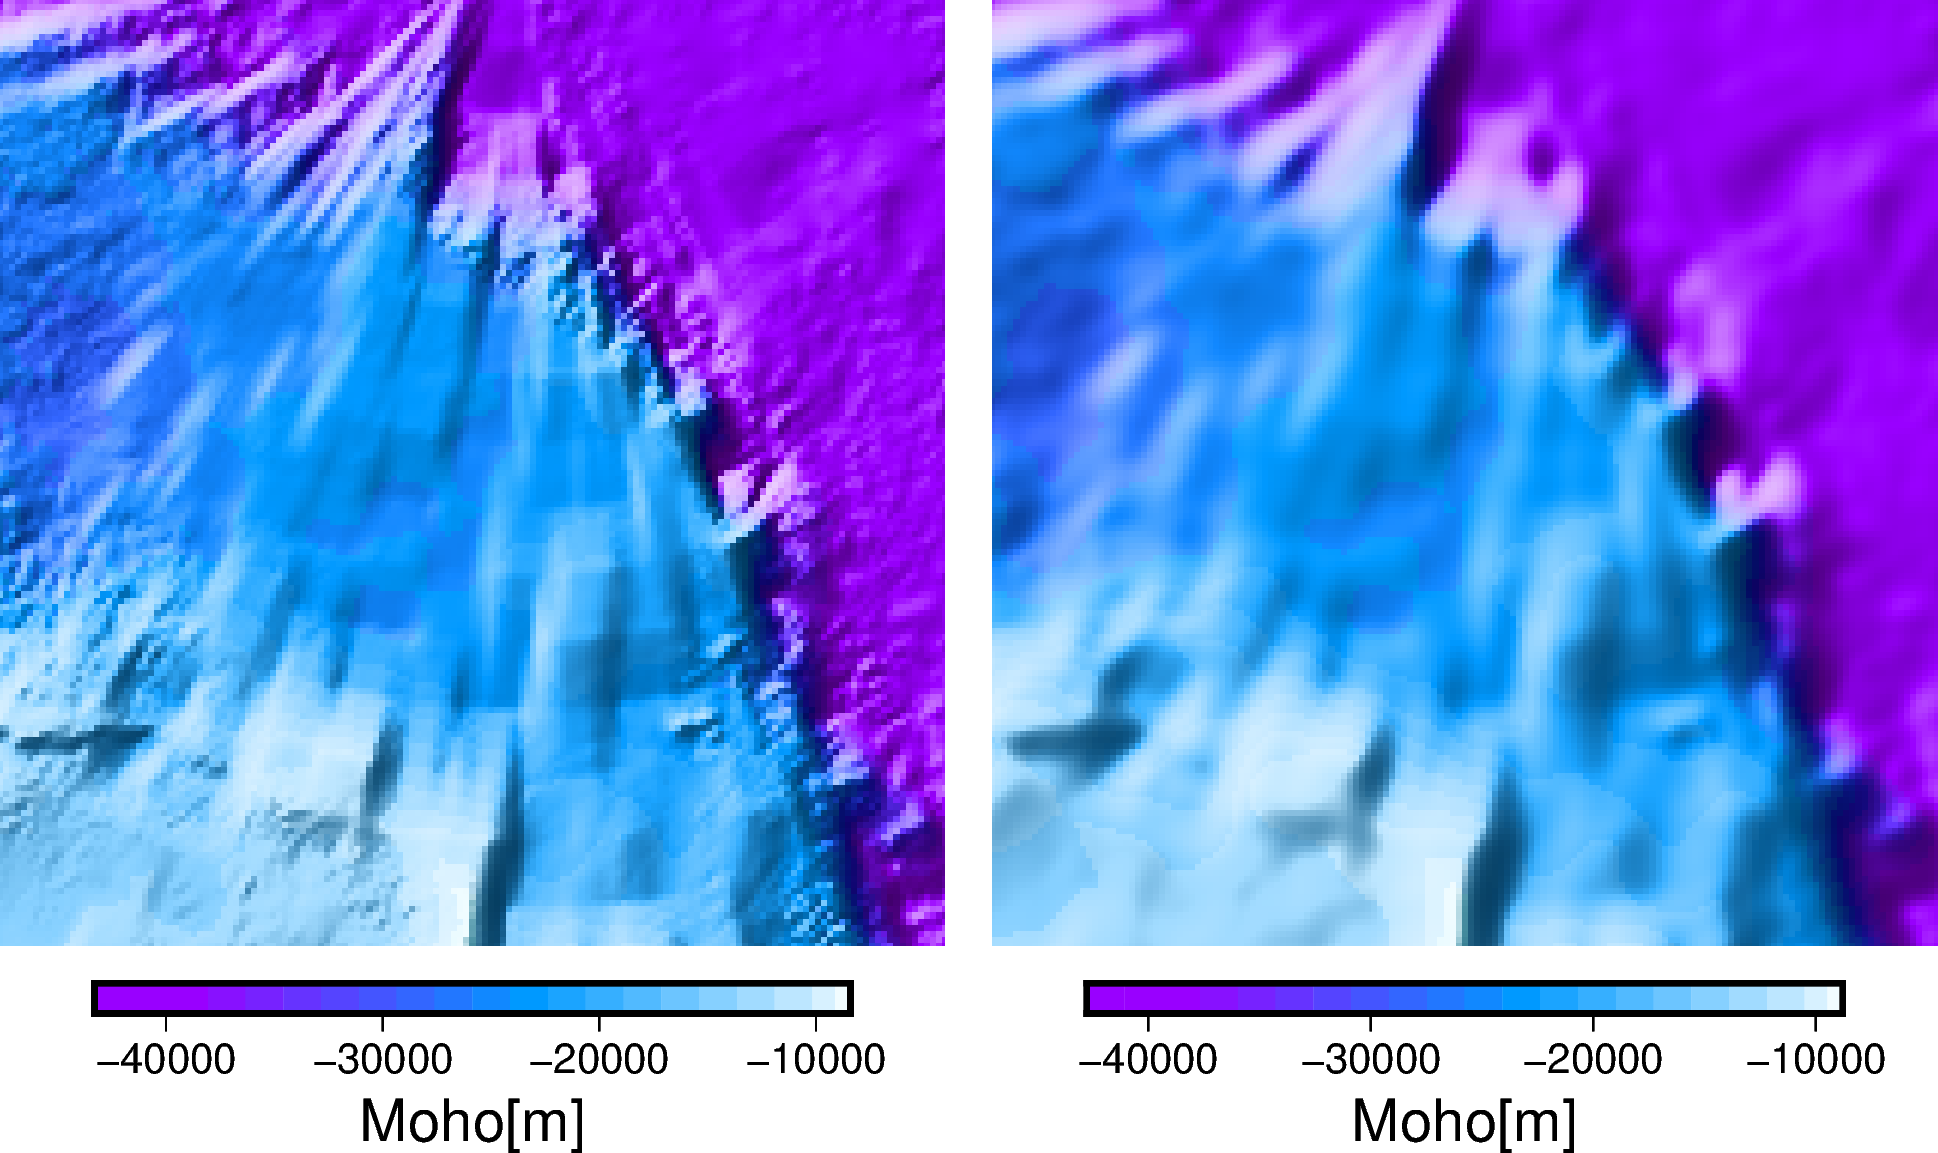

In [50]:
fname='/Volumes/arc_04/tankerma/Datasets/An_et_al_2015/AN1-CRUST.grd'
grid = pygmt.load_dataarray(fname)
Crust_An = grid.to_dataframe().reset_index()
Crust_An.z = Crust_An.z.apply(lambda x:x*1000)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
Crust_An['x'], Crust_An['y'] = transformer.transform(Crust_An.lat.tolist(), Crust_An.lon.tolist())

Crust_An = pygmt.blockmedian(Crust_An[['x','y','z']], spacing=10e3, registration='g', region='-1560000/1400000/-2400000/560000')

Crust_An = pygmt.surface(Crust_An[['x','y','z']], region='-1560000/1400000/-2400000/560000', 
    spacing=10e3, registration='g', M='1c')

# bedmap2_surface = pygmt.grdsample('inversion_layers/bedmap2_surface_filled.nc', 
#             region='-1560000/1400000/-2400000/560000', 
#             registration='g', spacing=10e3)         
# moho = bedmap2_surface - Crust_An

bedmap2_bed = pygmt.grdsample('/Volumes/arc_04/tankerma/Datasets/bedmap2/bedmap2_tiff/bedmap2_bed.tif', 
            region='-1560000/1400000/-2400000/560000', 
            registration='g', spacing=10e3)
moho = bedmap2_bed - Crust_An

fname='inversion_layers/An_moho.nc'
fig=pygmt.Figure()
fig.grdimage(grid = fname, 
            cmap = 'globe', 
            shading=True, 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa10e3+l"Moho[m]"')

fig.shift_origin(xshift="w+2c")

fname2='inversion_layers/An_moho_filt.nc'
pygmt.grdfilter(grid=fname, filter="g100e3", distance='0', outgrid=fname2)
fig.grdimage(grid = fname2, 
            cmap ='globe', 
            shading=True, 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa10e3+l"Moho[m]"')


fig.show()

grdproject [WARNING]: x_inc does not divide 180; geographic boundary condition changed to natural.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


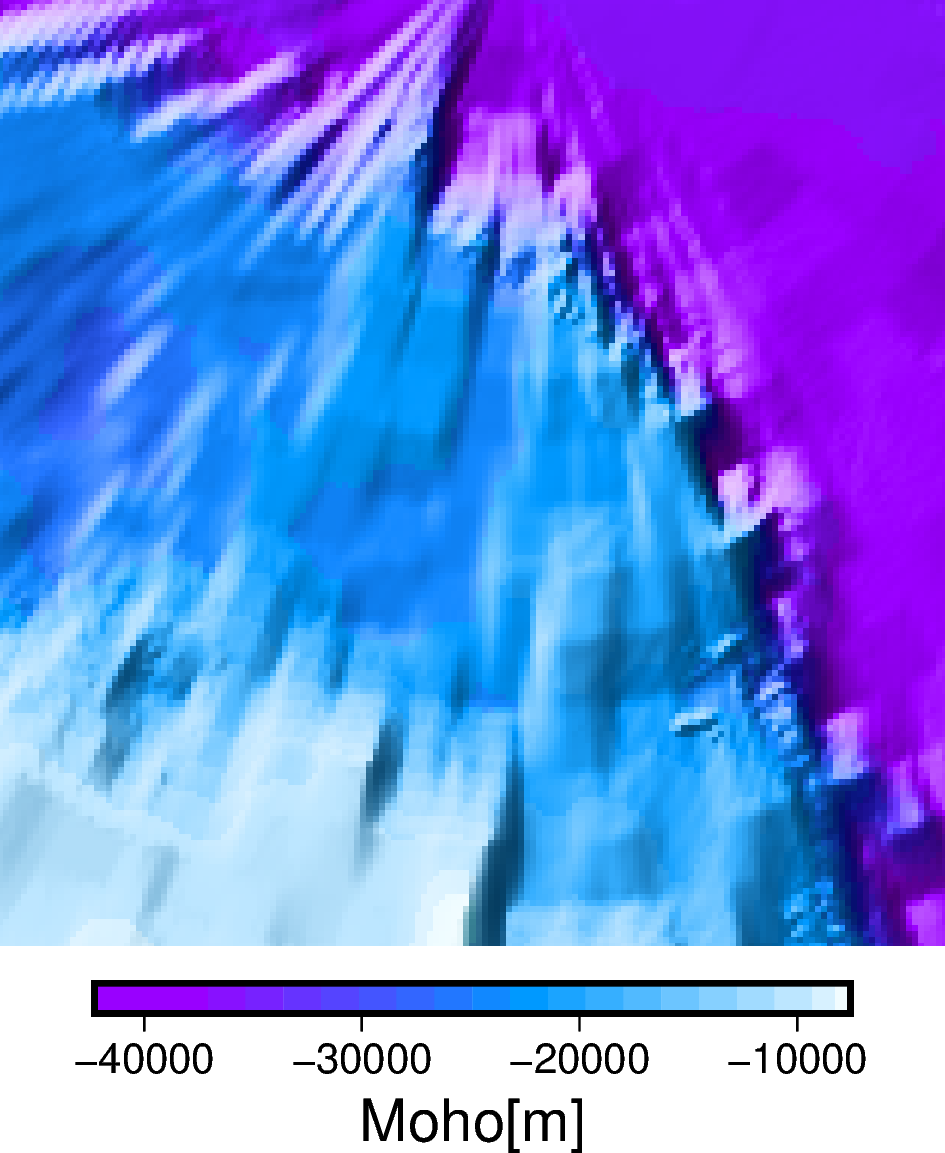

In [35]:
# fname='/Volumes/arc_04/tankerma/Datasets/An_et_al_2015/AN1-CRUST.grd'
# grid = pygmt.load_dataarray(fname)
# grid = pygmt.grdproject(grid, projection='EPSG:3031')
# grid = grid*1000
# crust = pygmt.grdsample(grid, region='-1560000/1400000/-2400000/560000', spacing=10e3, registration='g')

# bedmap2_surface = pygmt.grdsample('inversion_layers/bedmap2_surface_filled.nc', 
#             region='-1560000/1400000/-2400000/560000', 
#             registration='g', spacing=10e3)
# moho = bedmap2_surface - crust

# fname='inversion_layers/AN1-MOHO.nc'
# moho.to_netcdf(fname)
# moho = pygmt.load_dataarray(fname)

# fig=pygmt.Figure()
# grid=moho
# fig.grdimage(grid =grid, 
#             cmap ='globe', 
#             shading=True, 
#             projection=buffer_proj, 
#             region=buffer_reg, 
#             nan_transparent=True)
# fig.colorbar(cmap = True, frame = 'xa10e3+l"Moho[m]"')
# fig.show()

 Shen et al 2018: The Crust and Upper Mantle Structure ...

https://drive.google.com/drive/folders/1HRDedT44fzciNxodVmaXsYtLyxvck975

In [10]:
Moho_Shen = pd.read_csv('/Volumes/arc_04/tankerma/Datasets/Shen_et_al_2018/Shen_moho.final.dat', 
                        header=None, sep='\ ', engine='python')
Moho_Shen.columns =['Lon','Lat','z']
# Moho_Shen_uncert = pd.read_csv('/Volumes/arc_04/tankerma/Datasets/Shen_et_al_2018/Shen_un.moho.final.dat', header=None, sep='\ ', engine='python')
# Moho_Shen_uncert.columns =['Lon','Lat','uncert']
# Moho_Shen['uncert']=Moho_Shen_uncert.uncert
Moho_Shen.z=Moho_Shen.z.apply(lambda x:x*-1000)
# Moho_Shen.uncert=Moho_Shen.uncert.apply(lambda x:x*1000)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
Moho_Shen['x'], Moho_Shen['y'] = transformer.transform(Moho_Shen.Lat.tolist(), Moho_Shen.Lon.tolist())
Moho_Shen


,Lon,Lat,z,x,y
0,105.716284,-76.485358,-46155.509949,1.419828e+06,-399531.049253
1,106.705767,-76.415977,-46228.439331,1.420035e+06,-426186.599389
2,107.684801,-76.342507,-46350.440979,1.420255e+06,-452846.051497
3,65.351774,-75.945843,-44015.754700,1.394604e+06,639920.210736
4,66.260060,-76.047698,-44305.385590,1.394296e+06,613212.818773
...,...,...,...,...,...
9445,-98.997840,-73.034786,-33171.661377,-1.833510e+06,-290328.664254
9446,-99.799904,-72.994185,-32786.247253,-1.833707e+06,-316732.980045
9447,-95.666213,-72.913871,-34447.418213,-1.860639e+06,-184608.374855
9448,-96.468928,-72.887591,-34392.017364,-1.860769e+06,-210985.681330


/tmp/ipykernel_1661159/2420697901.py:3: FutureWarning: The 'outfile' parameter has been deprecated since v0.5.0 and will be removed in v0.7.0. Please use 'outgrid' instead.
  pygmt.surface(Moho_Shen[['x','y','z']], region='-1560000/1400000/-2400000/560000',


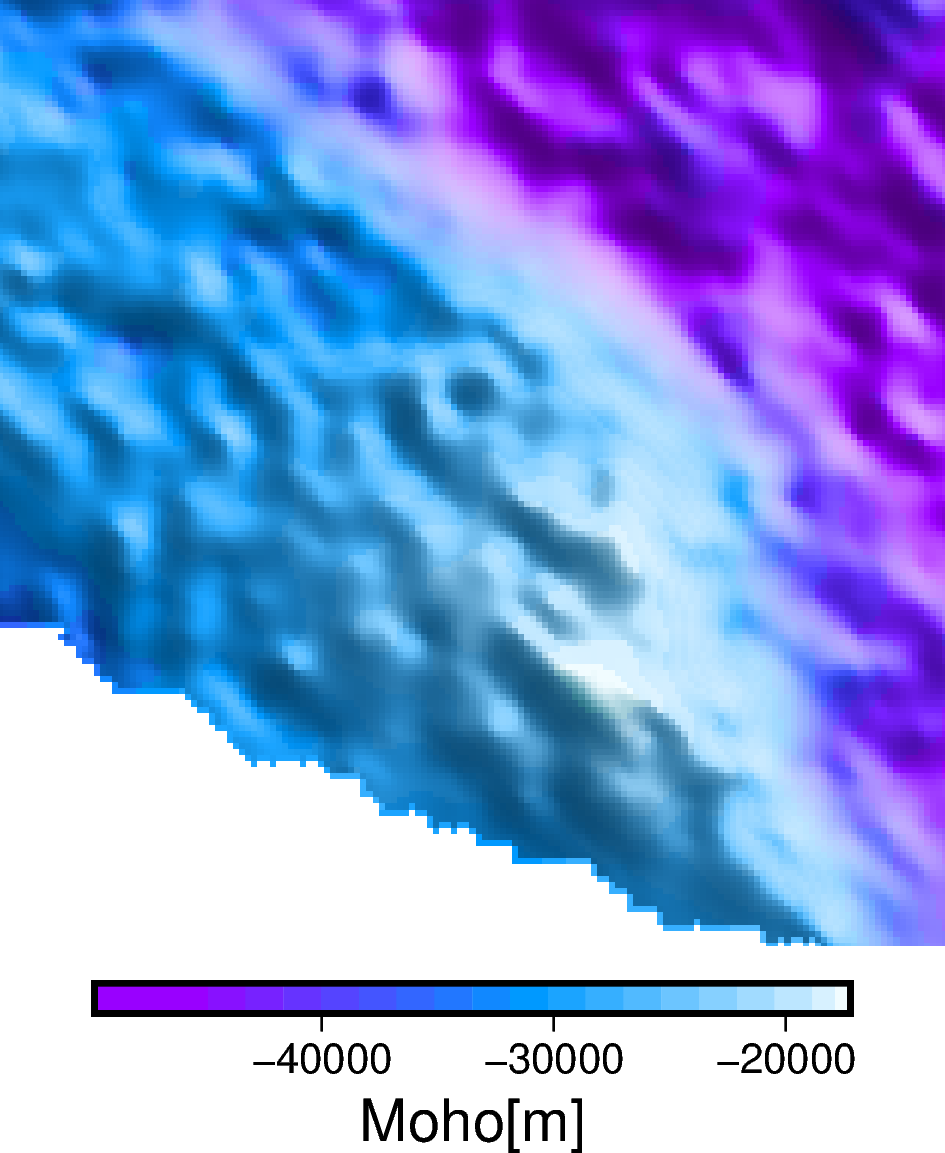

In [15]:
fname='inversion_layers/Shen_moho.nc'

pygmt.surface(Moho_Shen[['x','y','z']], region='-1560000/1400000/-2400000/560000', 
    spacing=10e3, registration='g', M='1c', outgrid=fname)

fig=pygmt.Figure()
grid=fname
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading='grdgradient+a45/45+nt1+m0', 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa10e3+l"Moho[m]"')
fig.show()

Pappa et al. 2019: Moho Depths of Antarctica ...
from https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018GC008111

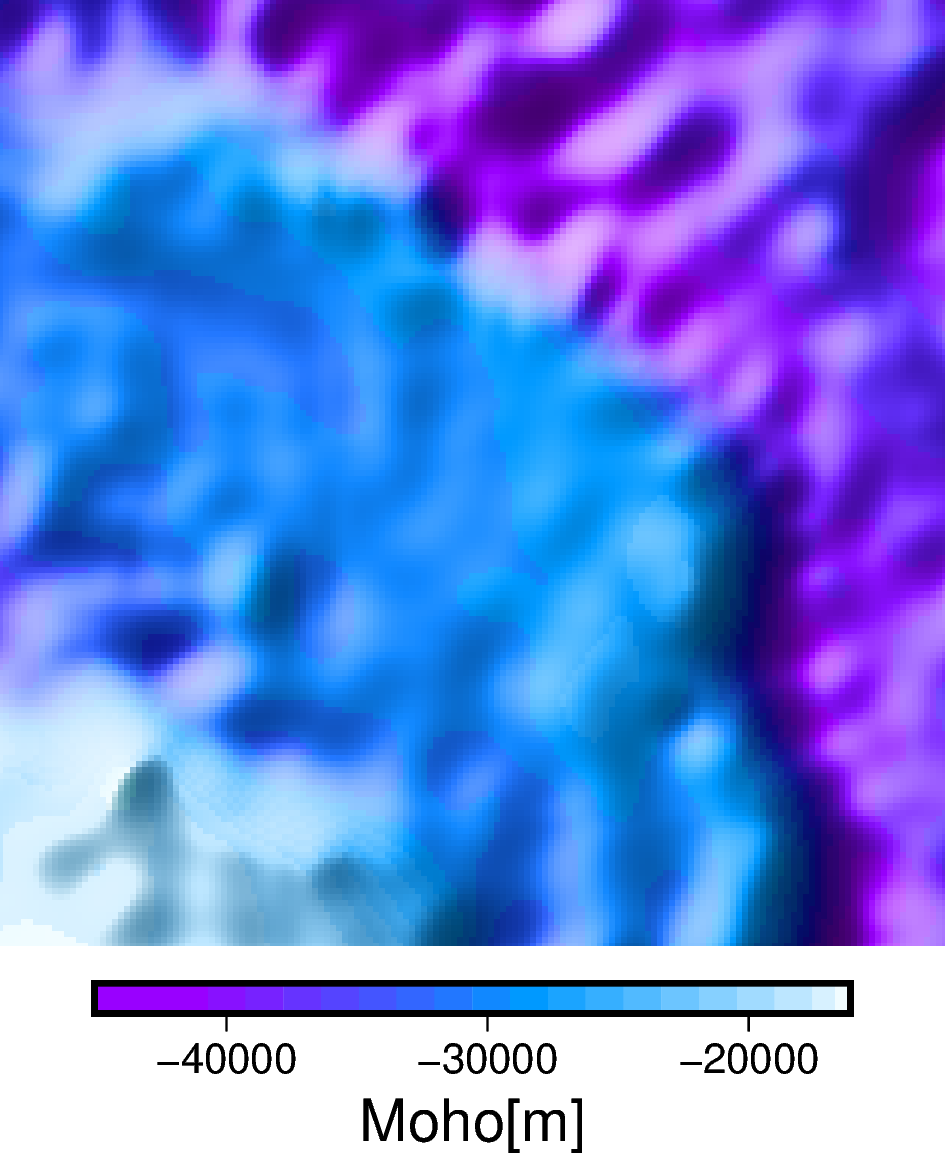

In [30]:
fname='/Volumes/arc_04/tankerma/Datasets/Pappa_et_al_2019_data/2018GC008111_Moho_depth_inverted_with_combined_depth_points.grd'
grid = pygmt.load_dataarray(fname)
Moho_Pappa = grid.to_dataframe().reset_index()
Moho_Pappa.z=Moho_Pappa.z.apply(lambda x:x*-1000)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
Moho_Pappa['x'], Moho_Pappa['y'] = transformer.transform(Moho_Pappa.lat.tolist(), Moho_Pappa.lon.tolist())

Moho_Pappa = pygmt.blockmedian(Moho_Pappa[['x','y','z']], spacing=10e3, registration='g', region='-1560000/1400000/-2400000/560000')

fname='inversion_layers/Pappa_moho.nc'

pygmt.surface(Moho_Pappa[['x','y','z']], region='-1560000/1400000/-2400000/560000', 
    spacing=10e3, registration='g', M='1c', outgrid=fname)
    
fig=pygmt.Figure()
grid=fname
fig.grdimage(grid =grid, 
            cmap ='globe', 
            shading=True, 
            projection=buffer_proj, 
            region=buffer_reg, 
            nan_transparent=True)
fig.colorbar(cmap = True, frame = 'xa10e3+l"Moho[m]"')
fig.show()

## GRAVITY

In [ ]:
ris_xl= -760_000
ris_yl= -1600_000 #N extent
ris_xh= 600_000
ris_yh= -350_000 #S extent
risreg = str(ris_xl) + '/' + str(ris_xh) + '/' + str(ris_yl) + '/' + str(ris_yh) #W/E/S/N
aerograv_data = "D:/ROSETTA_Data/from_LDEO_2021/rs_2019_grav.csv"
gravity = pd.read_csv(aerograv_data)
gravity = pygmt.blockmedian(table=gravity[["x", "y", "FAG_levelled"]], 
                                         spacing="5000+e", 
                                         region=risreg)
pygmt.surface(x=gravity.x, y=gravity.y, z=gravity.FAG_levelled,
              spacing='5000+e',
              outfile="layers/ROSETTA_gravity.nc",
              region=risreg,) 
!gmt grdmask ..\shapefiles\RIS_outline.shp -GRIS_mask.nc -I5000+e -R-760000/600000/-1600000/-350000 -NNaN/1/1
!gmt grdmath -Df layers/ROSETTA_gravity.nc RIS_mask.nc MUL = layers/ROSETTA_gravity.nc
!gmt grdsample layers/ROSETTA_gravity.nc -Glayers/ROSETTA_gravity.nc -T

In [ ]:
!gmt grd2xyz layers/ROSETTA_gravity.nc > layers/ROSETTA_gravity.csv

In [ ]:
print(pygmt.grdinfo("GRAV_50k.nc"))

In [ ]:
!gmt xyz2grd antgg_FAG_10k_RIS_hole_filled.xyz -GGRAV_10k.nc -I10000+e -R-760000/600000/-1600000/-240000

In [ ]:
!gmt grdsample GRAV_10k.nc -GGRAV_50k.nc -R-760000/600000/-1600000/-240000 -I50000+e -T

In [ ]:
!gmt grd2xyz GRAV_50k.nc > GRAV_50k_fromgrid.csv

In [ ]:
make_fig()

fig.grdimage(grid='GRAV_50k.nc', cmap="wysiwyg", nan_transparent=True, dpi='500')
fig.colorbar(cmap=True, position = pos_str, frame = 'xa10000+l"Moho Depth [m]"', box = '+gblack+p0.5p,black+c3p')
fig.show()


# Setup CSV's in format for inversion

In [ ]:
def edit_csvs(file_in, file_out, rho):
    df = pd.read_csv(file_in, header=None, index_col=None, sep='\t', names=('X','Y','Z'))
    df['RHO']=rho
    df['CP']=0
    df.to_csv(file_out, sep=',', index=False)

In [ ]:
edit_csvs('SURFACE_1k.csv', 'ICE_1k.csv', 0.92)

In [ ]:
edit_csvs('ICEBASE_1k.csv', 'WATER_1k.csv', 1.03)

In [ ]:
edit_csvs('BED_5k.csv', 'SEDIMENT_5k.csv', 2.3)

In [ ]:
edit_csvs('BASEMENT_5k.csv', 'CRUST_5k.csv', 2.8)

In [ ]:
edit_csvs('MOHO_5k.csv', 'MANTLE_5k.csv', 3.3)

In [ ]:
df = pd.read_csv('GRAV_50k_fromgrid.csv', header=None, index_col=None, sep='\t', names=('X','Y','FA'))
df['Z']=800
df['FACP']=df.FA
df.dropna(inplace=True)
df.to_csv('GRAV_50k.csv', sep=',', index=False)
df

In [ ]:
!gmt grdsample -R-760000/600000/-1600000/-240000 -I20e3 ROSETTA_gravity.nc -GROSETTA_gravity_20k.nc
!gmt grdsample -R-760000/600000/-1600000/-240000 -I20e3 BedMachine_surface_5k_filled.nc -GBedMachine_surface_filled_20k.nc
!gmt grdsample -R-760000/600000/-1600000/-240000 -I20e3 BedMachine_icebase_5k_filled.nc -GBedMachine_icebase_filled_20k.nc
!gmt grdsample -R-760000/600000/-1600000/-240000 -I20e3 BedMachine_bed_5k.nc -GBedMachine_bed_20k.nc 
!gmt grdsample -R-760000/600000/-1600000/-240000 -I20e3 ROSETTA_basement_BedMachine_bed.nc -GROSETTA_basement_BedMachine_bed_20k.nc 

!gmt grd2xyz -R-760000/600000/-1600000/-240000 ROSETTA_gravity_20k.nc > ROSETTA_gravity_20k.csv
!gmt grd2xyz -R-760000/600000/-1600000/-240000 BedMachine_surface_filled_20k.nc > BedMachine_surface_filled_20k.csv
!gmt grd2xyz -R-760000/600000/-1600000/-240000 BedMachine_icebase_filled_20k.nc > BedMachine_icebase_filled_20k.csv
!gmt grd2xyz -R-760000/600000/-1600000/-240000 BedMachine_bed_20k.nc > BedMachine_bed_20k.csv
!gmt grd2xyz -R-760000/600000/-1600000/-240000 ROSETTA_basement_BedMachine_bed_20k.nc > ROSETTA_basement_BedMachine_bed_20k.csv